In [1]:
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Use-Cases")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Use-Cases


In [2]:
from langchain_teddynote.models import get_model_name, LLMs

# 최신 버전의 모델명을 가져옵니다.
MODEL_NAME = get_model_name(LLMs.GPT4)
print(MODEL_NAME)

gpt-4o-mini


# 상태 정의

In [3]:
import operator
from typing import Sequence, Annotated
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage


# 상태 정의
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]  # 메시지
    next: str  # 다음으로 라우팅할 에이전트

# 에이전트 생성

In [4]:
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_experimental.tools import PythonREPLTool

# 최대 5개의 검색 결과를 반환하는 Tavily 검색 도구 초기화
tavily_tool = TavilySearch(max_results=5)

# 로컬에서 코드를 실행하는 Python REPL 도구 초기화 (안전하지 않을 수 있음)
python_repl_tool = PythonREPLTool()

# Agent 생성하는 Utility 구현

In [5]:
from langchain_core.messages import HumanMessage


# 지정한 agent와 name을 사용하여 agent 노드를 생성
def agent_node(state, agent, name):
    # agent 호출
    agent_response = agent.invoke(state)
    # agent의 마지막 메시지를 HumanMessage로 변환하여 반환
    return {
        "messages": [
            HumanMessage(content=agent_response["messages"][-1].content, name=name)
        ]
    }

In [6]:
import functools
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI


# Research Agent 생성
research_agent = create_react_agent(ChatOpenAI(model="gpt-4o"), tools=[tavily_tool])

# research node 생성
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

In [7]:
research_node(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
)

{'messages': [HumanMessage(content='To print "Hello, World!" to the terminal, you can use a simple script in various programming languages. Here are a few examples:\n\n### Python\n```python\nprint("Hello, World!")\n```\n\n### JavaScript (Node.js)\n```javascript\nconsole.log("Hello, World!");\n```\n\n### Java\n```java\npublic class HelloWorld {\n    public static void main(String[] args) {\n        System.out.println("Hello, World!");\n    }\n}\n```\n\n### C\n```c\n#include <stdio.h>\n\nint main() {\n    printf("Hello, World!\\n");\n    return 0;\n}\n```\n\n### Bash\n```bash\necho "Hello, World!"\n```\n\n### Ruby\n```ruby\nputs "Hello, World!"\n```\n\nYou can choose one of these examples and run it in the respective environment for each language. Let me know if you need instructions for running any of these examples!', additional_kwargs={}, response_metadata={}, name='Researcher')]}

In [8]:
from pydantic import BaseModel
from typing import Literal

# 멤버 Agent 목록 정의
members = ["Researcher", "Coder"]

# 다음 작업자 선택 옵션 목록 정의
options_for_next = ["FINISH"] + members


# 작업자 선택 응답 모델 정의: 다음 작업자를 선택하거나 작업 완료를 나타냄
class RouteResponse(BaseModel):
    next: Literal[*options_for_next]

In [9]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI


# 시스템 프롬프트 정의: 작업자 간의 대화를 관리하는 감독자 역할
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# ChatPromptTemplate 생성
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options_for_next), members=", ".join(members))


# LLM 초기화
llm = ChatOpenAI(model=MODEL_NAME, temperature=0)


# Supervisor Agent 생성
def supervisor_agent(state):
    # 프롬프트와 LLM을 결합하여 체인 구성
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)
    # Agent 호출
    return supervisor_chain.invoke(state)

# 그래프 구성

In [10]:
import functools
from langgraph.prebuilt import create_react_agent


# Research Agent 생성
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

code_system_prompt = """
Be sure to use the following font in your code for visualization.

##### 폰트 설정 #####
import platform

# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac 환경 폰트 설정
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    # 기본 한글 폰트 설정 시도
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")

##### 마이너스 폰트 깨짐 방지 #####
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 폰트 깨짐 방지
"""


# Coder Agent 생성
coder_agent = create_react_agent(
    llm,
    tools=[python_repl_tool],
    state_modifier=code_system_prompt,
)
coder_node = functools.partial(agent_node, agent=coder_agent, name="Coder")

In [11]:
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(AgentState)

# 그래프에 노드 추가
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", coder_node)
workflow.add_node("Supervisor", supervisor_agent)


# 멤버 노드 > Supervisor 노드로 엣지 추가
for member in members:
    workflow.add_edge(member, "Supervisor")

# 조건부 엣지 추가 (
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END


def get_next(state):
    return state["next"]


# Supervisor 노드에서 조건부 엣지 추가
workflow.add_conditional_edges("Supervisor", get_next, conditional_map)

# 시작점
workflow.add_edge(START, "Supervisor")

# 그래프 컴파일
graph = workflow.compile(checkpointer=MemorySaver())

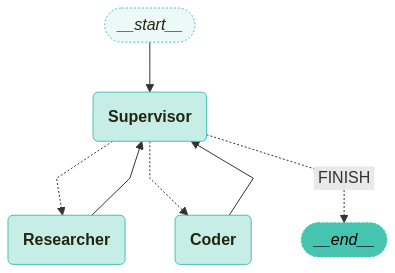

In [12]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

# 팀 호출


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
Researcher

🔄 Node: agent in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_web_search (call_3To3WkJ0GjONnrCmbrV39l1O)
 Call ID: call_3To3WkJ0GjONnrCmbrV39l1O
  Args:
    query: South Korea GDP per capita 2010 to 2024

🔄 Node: tools in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: tavily_web_search

[{"title": "South Korea GDP per capita 2024 - StatisticsTimes.com", "url": "https://statisticstimes.com/economy/country/south-korea-gdp-per-capita.php", "content": "South Korea GDP per capita 2024 - StatisticsTimes.com We use cookies GDP per capita of South Korea » GDP of South Korea According to the IMF World Economic Outlook (October 2024), South Korea's nominal GDP per capita in 2024 is

Python REPL can execute arbitrary code. Use with caution.



🔄 Node: agent in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  Python_REPL (call_cs6pC39f6SfNTXGLTIVJEtgQ)
 Call ID: call_cs6pC39f6SfNTXGLTIVJEtgQ
  Args:
    query: import matplotlib.pyplot as plt

# 데이터
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
gdp_per_capita = [23079, 25098, 25459, 27180, 29253, 28737, 29280, 31601, 33447, 31902, 31721, 35126, 32395, 33121, 36132]

# 그래프 시각화
plt.figure(figsize=(10, 5))
plt.plot(years, gdp_per_capita, marker='o')
plt.title('South Korea GDP per Capita (2010-2024)')
plt.xlabel('Year')
plt.ylabel('GDP per Capita (USD)')
plt.xticks(years)
plt.grid()
plt.show()


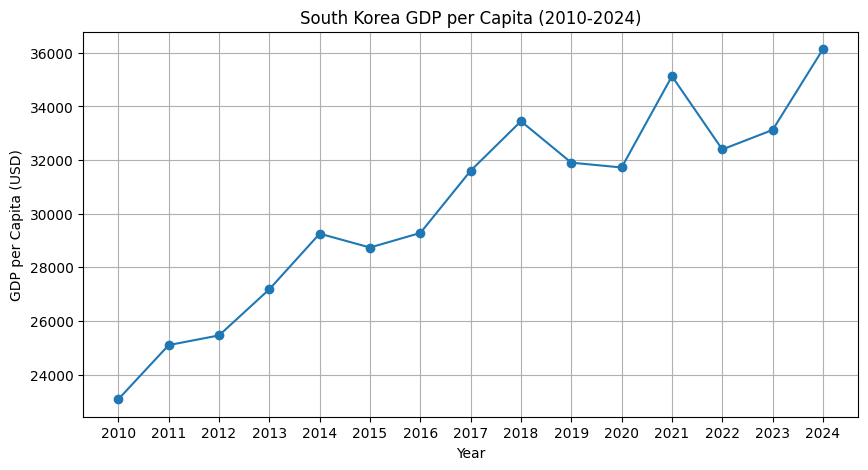


🔄 Node: tools in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: Python_REPL



🔄 Node: agent in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================

그래프를 통해 2010년부터 2024년까지의 대한민국의 1인당 GDP 추이를 시각화한 결과는 다음과 같습니다. 

- 2010년부터 2014년까지는 꾸준히 증가하다가 2015년에 소폭 감소하였고, 이후 다시 증가세를 보였습니다.
- 2020년에는 코로나19의 영향으로 약간의 감소가 있었으나, 2021년부터 다시 상승세를 이어가고 있습니다.
- 2024년은 예상치로, 36,132 USD로 나타나고 있습니다.

이 그래프는 대한민국의 경제 성장 추세를 잘 보여줍니다.

🔄 Node: Coder 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: Coder

그래프를 통해 2010년부터 2024년까지의 대한민국의 1인당 GDP 추이를 시각화한 결과는 다음과 같습니다. 

- 2010년부터 2014년까지는 꾸준히 증가하다가 2015년에 소폭 감소하였고, 이후 다시 증가세를 보였습니다.
- 2020년에는 코로나19의 영향으로 약간의 감소가 있었으나, 2021년부터 다시 상승세를 이어가고 있습니다.
- 2024년은 예상치로, 36,132 USD로 나타나고 있습니다.

이 그래프

In [13]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="2010년 ~ 2024년까지의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요."
        )
    ],
}

# 그래프 실행
invoke_graph(graph, inputs, config)